In [1]:
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from numpy import array
from numpy import argmax
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

In [5]:
from pyspark.sql import SparkSession 
 
spark_session = SparkSession.builder\
        .master("spark://host-192-168-2-139:7077") \
        .appName("Scaling test")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", 8)\
        .config("spark.ui.reverseProxy", True)\
        .config("spark.ui.reverseProxyUrl", "http://130.238.28.204:4040/")\
        .getOrCreate()

In [19]:
#csv_file = spark_session.read.csv('file:///home/ubuntu/musicdata/')
import time
time_collection = []
for parts in range(1,9):
    section_times = []
    print("Running timing for " + str(parts) + "partitions")
    section_times.append(parts)
    start_time = time.time()
    s_time = time.time() - start_time
    
    """ PRE-PROCESSING """
    csv_file = spark_session.read.csv('file:///home/ubuntu/musicdata/').rdd

    csv_file = csv_file.repartition(parts)

    csv_file = csv_file.map(lambda x : [float(c) for c in x[1:-1]]).cache().toDF()

    labels_file = pd.read_table('file:///home/ubuntu/ML/labels.txt')
    labels = labels_file.columns[0]
    labels_list = labels.split(',')
    labels_list = labels_list[1:-1]
    csv_file = csv_file.toDF(*labels_list)
    ignore = ['generaid', "don`t", "i`m", "can`t"]
    assembler = VectorAssembler(
        inputCols=[x for x in csv_file.columns if x not in ignore],
        outputCol='features')

    data_assembled = assembler.transform(csv_file)
    training, test = data_assembled.randomSplit([0.8, 0.2])
    
    section_times.append(s_time-time.time())
    s_time = time.time() - start_time
    
    """ LOGISTIC REGRESSION """
    lr = LogisticRegression(maxIter=10, regParam=0.01, labelCol="generaid")
    # print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
    model1 = lr.fit(training)
    lr_pred = model1.transform(test)
    lr_evaluator = MulticlassClassificationEvaluator(
        labelCol="generaid", predictionCol="prediction", metricName="accuracy")
    lr_accuracy = lr_evaluator.evaluate(lr_pred)
    print(lr_accuracy)
    
    section_times.append(s_time-time.time())
    s_time = time.time() - start_time

    """ DECISION TREE """
    tree2 = DecisionTreeClassifier(labelCol="generaid")
    tree_model2 = tree2.fit(training)
    tree_predictions = tree_model2.transform(test)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="generaid", predictionCol="prediction", metricName="accuracy")
    tree_accuracy = evaluator.evaluate(tree_predictions)
    print(tree_accuracy)
    
    section_times.append(s_time-time.time())
    s_time = time.time() - start_time

    """ NAIVE BAYES """
    nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
    bayes_model = nb.fit(training)
    bayes_predictions = bayes_model.transform(test)
    bayes_evaluator = MulticlassClassificationEvaluator(labelCol="generaid", predictionCol="prediction",
                                                  metricName="accuracy")
    bayes_accuracy = bayes_evaluator.evaluate(bayes_predictions)
    print(bayes_accuracy)
    
    section_times.append(s_time-time.time())
    s_time = time.time() - start_time
    section_times.append(s_time)
    time_collection.append[section_times]

Running timing for 1partitions


23/03/14 10:40:00 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:40:54 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:41:47 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:47 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:51 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:53 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:41:53 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/03/14 10:43:47 WARN DAGScheduler: Broadcasting larg

0.5794952037553575
23/03/14 10:47:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:49:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:50:30 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:51:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 10:52:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/03/14 10:53:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/03/14 10:53:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/03/14 10:53:33 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/03/14 10:53:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/03/14 10:55:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


0.5286073882577046
23/03/14 10:59:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/03/14 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/03/14 11:02:22 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


0.49765290155792913


TypeError: 'builtin_function_or_method' object is not subscriptable

In [21]:
print(section_times)

[1, -1678790292.9543176, -1678790510.5094132, -1678790863.7607992, -1678790497.6212275, 1672.164003610611]


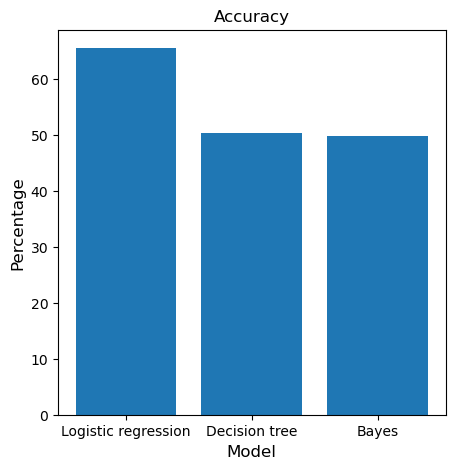

In [66]:
plt.figure(figsize=(5, 5))
x_input = ['Logistic regression', 'Decision tree', 'Bayes']
y_input = [lr_accuracy*100, tree_accuracy*100, bayes_accuracy*100]
plt.bar(x_input, y_input)
plt.title('Accuracy')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()

In [4]:
spark_session.stop()